In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cmo
import seaborn as sb

In [2]:
def format_composite(ds, var): 
    test = ds[f'snap_{var}_anom']
    test = xr.where(abs(test)>1e10, np.nan, test)
    test = xr.where(test==0, np.nan, test)

    X = np.meshgrid(ds.x.data,ds.y.data)
    mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])
    masked_var = xr.where(mask, test, np.nan)

    # subsample for periods that we have ocean output (daily, timestamp is 12:00:00)

    ds.snap_time.dt.hour == 12
    time = ds.snap_time[ds.snap_time.dt.hour == 12]
    snap = ds.snapshot[ds.snap_time.dt.hour == 12]
    lat = ds.snap_lat[ds.snap_time.dt.hour == 12]
    lon = ds.snap_lon[ds.snap_time.dt.hour == 12]
    
    lon = xr.where(lon < 0, 360 + lon, lon)

    flux = masked_var[:,:,ds.snap_time.dt.hour == 12]

    # create a dataset to group snapshots by day of year

    ds_masked = ds = xr.Dataset(
        data_vars=dict(
            flux=(["x", "y", "snapshot"], flux.data),
            time=(["snapshot"], time.data),
            lat=(["snapshot"], lat.data),
            lon=(["snapshot"], lon.data),
        ),
        coords=dict(
            x=ds.x.data,
            y=ds.y.data,
            snapshot=snap.data,
        ),
        attrs=dict(description=f"{var} snapshots"),
    )
    
    return ds_masked

In [3]:
ds_cm = xr.open_dataset(f'/work/Katherine.Turner/tempest-extremes/odiv-251/comp_f_dic/comp_dic_stf_gas_anom.nc', use_cftime=True)
ds_esm = xr.open_dataset(f'/work/Katherine.Turner/tempest-extremes/ESM4/dic_stf_gas/comp_dic_stf_gas_anom.nc', use_cftime=True)

In [14]:
H, np.histogram2d(ds_cm.snap_lon.data, ds_cm.snap_lat.data)

(array([[1.1000e+01, 9.0000e+01, 7.0500e+02, 7.9110e+03, 2.5738e+04,
         2.3123e+04, 1.6716e+04, 9.5020e+03, 4.8360e+03, 1.8790e+03],
        [2.2000e+01, 3.7000e+01, 8.6000e+01, 2.2150e+03, 2.3456e+04,
         2.1954e+04, 1.3609e+04, 9.2560e+03, 6.5460e+03, 3.9170e+03],
        [1.4000e+01, 5.2000e+01, 8.5000e+01, 1.8100e+03, 2.2786e+04,
         2.4897e+04, 1.5845e+04, 8.4720e+03, 3.7250e+03, 1.4150e+03],
        [3.4000e+01, 8.6000e+01, 1.0600e+02, 1.4830e+03, 2.5866e+04,
         2.4018e+04, 1.4691e+04, 7.3050e+03, 3.3840e+03, 1.3300e+03],
        [7.6700e+02, 9.0600e+02, 4.3430e+03, 1.1820e+04, 2.2542e+04,
         1.4501e+04, 1.0138e+04, 7.7150e+03, 7.8390e+03, 5.4400e+03],
        [2.0800e+02, 2.3640e+03, 1.0003e+04, 1.9451e+04, 1.6475e+04,
         1.2075e+04, 9.7200e+03, 1.1097e+04, 1.2342e+04, 8.6280e+03],
        [9.4000e+01, 1.0450e+03, 5.9960e+03, 1.5793e+04, 1.6467e+04,
         1.3563e+04, 1.0835e+04, 1.1094e+04, 1.1580e+04, 7.5190e+03],
        [4.4000e+01, 5.1800

In [4]:
dic_cm = format_composite(ds_cm, 'dic_stf_gas')
dic_esm = format_composite(ds_esm, 'dic_stf_gas')

In [5]:
lat_full = np.arange(-88.5,-29.5, 1)
lon_full = np.arange(0.625, 360.625, 1.25)

In [6]:
def bin_storm_anomalies(ds):
    storm_fluxes = np.ones([len(lat_full), len(lon_full)])*np.nan
    storm_fluxes_DJF = np.ones([len(lat_full), len(lon_full)])*np.nan
    storm_fluxes_JJA = np.ones([len(lat_full), len(lon_full)])*np.nan

    nstorm = np.ones([len(lat_full), len(lon_full)])*np.nan
    nstorm_DJF = np.ones([len(lat_full), len(lon_full)])*np.nan
    nstorm_JJA = np.ones([len(lat_full), len(lon_full)])*np.nan

    idx_JJA = ds.time.dt.season == "JJA"
    idx_DJF = ds.time.dt.season == "DJF"

    for i1, ilat  in enumerate(lat_full):
        idx_lat = (ds.lat.data == ilat)
        if sum(idx_lat) > 0:
            for i2, ilon in enumerate(lon_full):
                idx = idx_lat & (ds.lon.data == ilon)
                if sum(idx) > 0:
                    storm_fluxes[i1, i2] = ds.flux[:, :, idx].sum()
                    storm_fluxes_JJA[i1, i2] = ds.flux[:, :, idx & idx_JJA].sum()
                    storm_fluxes_DJF[i1, i2] = ds.flux[:, :, idx & idx_DJF].sum()
                
                    nstorm[i1, i2] = ds.flux[:, :, idx].mean()
                    nstorm_JJA[i1, i2] = ds.flux[:, :, idx & idx_JJA].mean()
                    nstorm_DJF[i1, i2] = ds.flux[:, :, idx & idx_DJF].mean()
    return storm_fluxes, storm_fluxes_JJA, storm_fluxes_DJF, nstorm, nstorm_JJA, nstorm_DJF

In [7]:
cm_storm_fluxes, cm_storm_fluxes_JJA, cm_storm_fluxes_DJF, cm_nstorm, cm_nstorm_JJA, cm_nstorm_DJF = bin_storm_anomalies(dic_cm)
esm_storm_fluxes, esm_storm_fluxes_JJA, esm_storm_fluxes_DJF, esm_nstorm, esm_nstorm_JJA, esm_nstorm_DJF = bin_storm_anomalies(dic_esm)

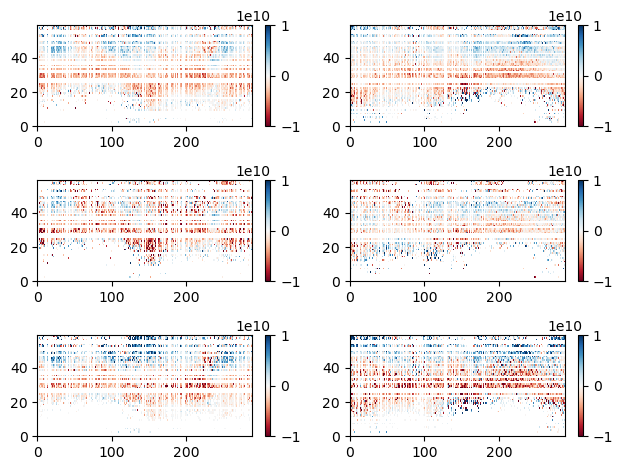

In [8]:
c = (.5*111)**2 * 1e6 * (60**2 * 24) * 1e3

fig, axs = plt.subplots(ncols=2, nrows=3)
axs=axs.flatten()

im = axs[0].pcolormesh(c * cm_nstorm, vmin=-1e10, vmax=1e10, cmap = "RdBu")
plt.colorbar(im, ax=axs[0])

im = axs[2].pcolormesh(c * cm_nstorm_DJF, vmin=-1e10, vmax=1e10, cmap = "RdBu")
plt.colorbar(im, ax=axs[2])

im = axs[4].pcolormesh(c * cm_nstorm_JJA, vmin=-1e10, vmax=1e10, cmap = "RdBu")
plt.colorbar(im, ax=axs[4])

im = axs[1].pcolormesh(c * esm_nstorm, vmin=-1e10, vmax=1e10, cmap = "RdBu")
plt.colorbar(im, ax=axs[1])

im = axs[3].pcolormesh(c * esm_nstorm_DJF, vmin=-1e10, vmax=1e10, cmap = "RdBu")
plt.colorbar(im, ax=axs[3])

im = axs[5].pcolormesh(c * esm_nstorm_JJA, vmin=-1e10, vmax=1e10, cmap = "RdBu")
plt.colorbar(im, ax=axs[5])

plt.tight_layout()

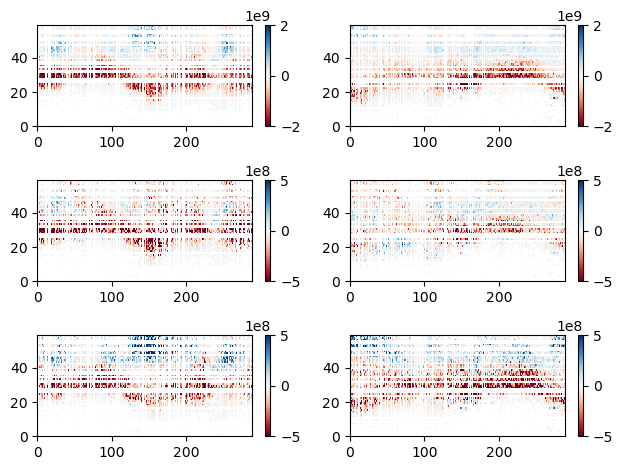

In [129]:
c = (.5*111)**2 * 1e6 * (60**2 * 24)

fig, axs = plt.subplots(ncols=2, nrows=3)
axs=axs.flatten()

im = axs[0].pcolormesh(c * cm_storm_fluxes / 95, vmin=-2e9, vmax=2e9, cmap = "RdBu")
plt.colorbar(im, ax=axs[0])

im = axs[2].pcolormesh(c * cm_storm_fluxes_DJF / 95, vmin=-5e8, vmax=5e8, cmap = "RdBu")
plt.colorbar(im, ax=axs[2])

im = axs[4].pcolormesh(c * cm_storm_fluxes_JJA / 95, vmin=-5e8, vmax=5e8, cmap = "RdBu")
plt.colorbar(im, ax=axs[4])

im = axs[1].pcolormesh(c * esm_storm_fluxes / 100, vmin=-2e9, vmax=2e9, cmap = "RdBu")
plt.colorbar(im, ax=axs[1])

im = axs[3].pcolormesh(c * esm_storm_fluxes_DJF / 100, vmin=-5e8, vmax=5e8, cmap = "RdBu")
plt.colorbar(im, ax=axs[3])

im = axs[5].pcolormesh(c * esm_storm_fluxes_JJA / 100, vmin=-5e8, vmax=5e8, cmap = "RdBu")
plt.colorbar(im, ax=axs[5])

plt.tight_layout()

In [130]:
import cartopy.crs as ccrs
import matplotlib.path as mpath

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

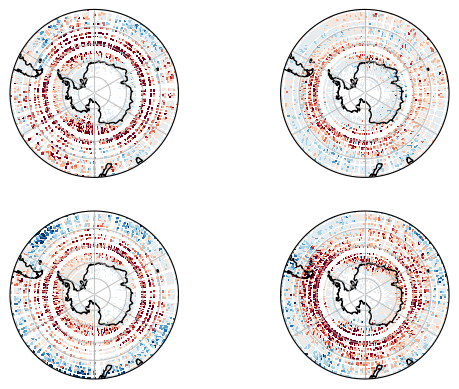

In [151]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.flatten()

###################### CM4 HISTOGRAMS ##############################

axs[0].pcolormesh(lon_full, lat_full, (c * cm_storm_fluxes_DJF / 95), transform=ccrs.PlateCarree(),
                                    cmap=plt.get_cmap('RdBu', 10),
                                    vmin = -5e8, vmax=5e8)

axs[1].pcolormesh(lon_full, lat_full, (c * esm_storm_fluxes_DJF / 100), transform=ccrs.PlateCarree(),
                                    cmap=plt.get_cmap('RdBu', 10),
                                    vmin = -5e8, vmax=5e8)

axs[2].pcolormesh(lon_full, lat_full, (c * cm_storm_fluxes_JJA / 95), transform=ccrs.PlateCarree(),
                                    cmap=plt.get_cmap('RdBu', 10),
                                    vmin = -5e8, vmax=5e8)

axs[3].pcolormesh(lon_full, lat_full, (c * esm_storm_fluxes_JJA / 100), transform=ccrs.PlateCarree(),
                                    cmap=plt.get_cmap('RdBu', 10),
                                    vmin = -5e8, vmax=5e8)
#axs[0].set_title("(a) Average storm density")

for i in np.arange(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(9,5.5))
axs=axs.flatten()

hfds_doy[:,:,0:31].mean('dayofyear').plot(y='y', ax=axs[0], vmin=-40, vmax=40, extend='neither', cmap=plt.get_cmap('RdBu'),
                                              cbar_kwargs={"aspect":15, "shrink":0.9, "label":"W m$^{-2}$"})
hfds_doy[:,:,31:59].mean('dayofyear').plot(y='y', ax=axs[1], vmin=-40, vmax=40, extend='neither', cmap=plt.get_cmap('RdBu'),
                                              cbar_kwargs={"aspect":15, "shrink":0.9, "label":"W m$^{-2}$"})
hfds_doy[:,:,59:90].mean('dayofyear').plot(y='y', ax=axs[2], vmin=-40, vmax=40, extend='neither', cmap=plt.get_cmap('RdBu'),
                                              cbar_kwargs={"aspect":15, "shrink":0.9, "label":"W m$^{-2}$"})
hfds_doy[:,:,90:120].mean('dayofyear').plot(y='y', ax=axs[3], vmin=-40, vmax=40, extend='neither', cmap=plt.get_cmap('RdBu'),
                                              cbar_kwargs={"aspect":15, "shrink":0.9, "label":"W m$^{-2}$"})
hfds_doy[:,:,120:151].mean('dayofyear').plot(y='y', ax=axs[4], vmin=-40, vmax=40, extend='neither', cmap=plt.get_cmap('RdBu'),
                                              cbar_kwargs={"aspect":15, "shrink":0.9, "label":"W m$^{-2}$"})
hfds_doy[:,:,151:181].mean('dayofyear').plot(y='y', ax=axs[5], vmin=-40, vmax=40, extend='neither', cmap=plt.get_cmap('RdBu'),
                                              cbar_kwargs={"aspect":15, "shrink":0.9, "label":"W m$^{-2}$"})
hfds_doy[:,:,181:212].mean('dayofyear').plot(y='y', ax=axs[6], vmin=-40, vmax=40, extend='neither', cmap=plt.get_cmap('RdBu'),
                                              cbar_kwargs={"aspect":15, "shrink":0.9, "label":"W m$^{-2}$"})
hfds_doy[:,:,212:243].mean('dayofyear').plot(y='y', ax=axs[7], vmin=-40, vmax=40, extend='neither', cmap=plt.get_cmap('RdBu'),
                                              cbar_kwargs={"aspect":15, "shrink":0.9, "label":"W m$^{-2}$"})
hfds_doy[:,:,243:273].mean('dayofyear').plot(y='y', ax=axs[8], vmin=-40, vmax=40, extend='neither', cmap=plt.get_cmap('RdBu'),
                                              cbar_kwargs={"aspect":15, "shrink":0.9, "label":"W m$^{-2}$"})
hfds_doy[:,:,273:304].mean('dayofyear').plot(y='y', ax=axs[9], vmin=-40, vmax=40, extend='neither', cmap=plt.get_cmap('RdBu'),
                                              cbar_kwargs={"aspect":15, "shrink":0.9, "label":"W m$^{-2}$"})
hfds_doy[:,:,304:334].mean('dayofyear').plot(y='y', ax=axs[10], vmin=-40, vmax=40, extend='neither', cmap=plt.get_cmap('RdBu'),
                                              cbar_kwargs={"aspect":15, "shrink":0.9, "label":"W m$^{-2}$"})
hfds_doy[:,:,334:365].mean('dayofyear').plot(y='y', ax=axs[11], vmin=-40, vmax=40, extend='neither', cmap=plt.get_cmap('RdBu'),
                                              cbar_kwargs={"aspect":15, "shrink":0.9, "label":"W m$^{-2}$"})



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


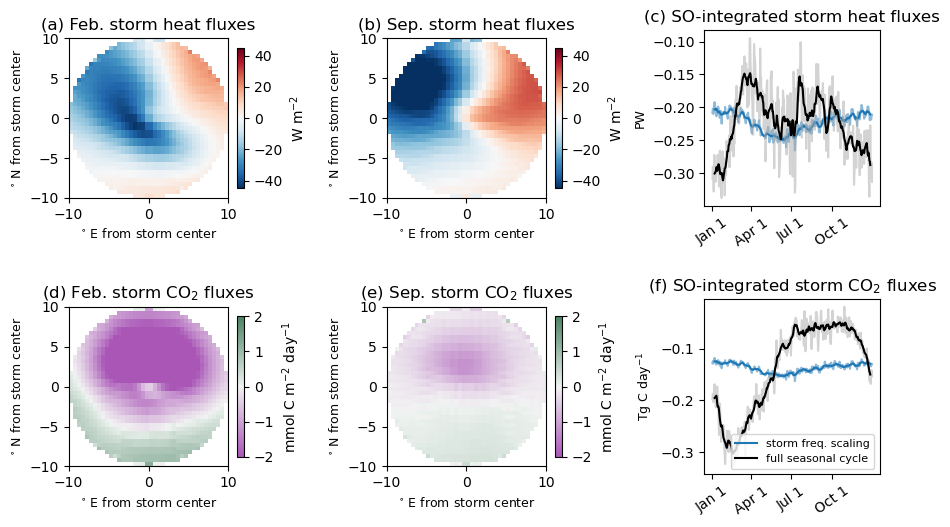

In [30]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9,5.5))
axs=axs.flatten()

hfds_doy[:,:,31:59].mean('dayofyear').plot(y='y', ax=axs[0], vmin=-45, vmax=45, extend='neither', cmap=plt.get_cmap('RdBu_r'),
                                              cbar_kwargs={"aspect":20, "shrink":0.8, "fraction":0.04, "label":"W m$^{-2}$"})

hfds_doy[:,:,242:273].mean('dayofyear').plot(y='y', ax=axs[1], vmin=-45, vmax=45, extend='neither', cmap=plt.get_cmap('RdBu_r'),
                                                #cbar_kwargs={"aspect":15, "shrink":0.9, "label":"W m$^{-2}$"})
                                                cbar_kwargs={"aspect":20, "shrink":0.8, "fraction":0.04, "label":"W m$^{-2}$"})

(1e-15*hfds_ann_cycle_1).plot(ax=axs[2], alpha=0.5)
(1e-15*hfds_ann_cycle_1).rolling(dayofyear=10, center=True).mean().plot(ax=axs[2], color='#1f77b4')
(1e-15*hfds_ann_cycle_2).plot(ax=axs[2], color='darkgrey', alpha=0.5)
(1e-15*hfds_ann_cycle_2).rolling(dayofyear=10, center=True).mean().plot(ax=axs[2], color='black')

(1e3* 60**2 * 24 * dic_doy[:,:,31:59]).mean('dayofyear').plot(y='y', ax=axs[3], vmin=-2, vmax=2, extend='neither', 
                                                              cmap=sb.diverging_palette(300, 145, s=60, as_cmap=True),
                                              #cbar_kwargs={"aspect":15, "shrink":0.9, "label":"mmol C m$^{-2}$ day$^{-1}$"})
                                              cbar_kwargs={"aspect":20, "shrink":0.8, "fraction":0.04, "label":"mmol C m$^{-2}$ day$^{-1}$"})

(1e3* 60**2 * 24 *dic_doy[:,:,242:273]).mean('dayofyear').plot(y='y', ax=axs[4], vmin=-2, vmax=2, extend='neither', 
                                                               cmap=sb.diverging_palette(300, 145, s=60, as_cmap=True),
                                              #cbar_kwargs={"aspect":15, "shrink":0.9, "label":"mmol C m$^{-2}$ day$^{-1}$"})
                                              cbar_kwargs={"aspect":20, "shrink":0.8, "fraction":0.04, "label":"mmol C m$^{-2}$ day$^{-1}$"})

(1e-12 * dic_ann_cycle_1).plot(ax=axs[5], alpha=0.5)
(1e-12 * dic_ann_cycle_1).rolling(dayofyear=10, center=True).mean().plot(ax=axs[5], color='#1f77b4', label="storm freq. scaling")
(1e-12 * dic_ann_cycle_2).plot(ax=axs[5], color='darkgrey', alpha=0.5)
(1e-12 * dic_ann_cycle_2).rolling(dayofyear=10, center=True).mean().plot(ax=axs[5], color='black', label="full seasonal cycle")
axs[5].legend(fontsize=8)

titles = ["(a) Feb. storm heat fluxes", 
          "(b) Sep. storm heat fluxes", 
          "(c) SO-integrated storm heat fluxes",
          "(d) Feb. storm CO$_2$ fluxes",
          "(e) Sep. storm CO$_2$ fluxes",
          "(f) SO-integrated storm CO$_2$ fluxes"]

for i in np.arange(6):
    axs[i].set_box_aspect(1)
    axs[i].set_xlabel('$^{\circ}$ E from storm center', fontsize=9)
    axs[i].set_ylabel('$^{\circ}$ N from storm center', fontsize=9)
    axs[i].set_title(titles[i])
    
axs[2].set_ylabel('PW', fontsize=9)
axs[2].set_xlabel('')
axs[5].set_ylabel('Tg C day$^{-1}$', fontsize=9)
axs[5].set_xlabel('')

for i in [2,5]:
    axs[i].set_xticks([0, 90, 181, 273])
    axs[i].set_xticklabels(['Jan 1', 'Apr 1', 'Jul 1', 'Oct 1'])
    axs[i].tick_params(axis='x', rotation=35)

plt.tight_layout()
plt.savefig("/work/Katherine.Turner/CM4_storms/analysis_figures/CM4_seasonal_composites.png", dpi=100, format="png", bbox_inches="tight")
plt.savefig("/home/Katherine.Turner/Figures/CM4_seasonal_composites.png", dpi=100, format="png", bbox_inches="tight")
plt.savefig("/home/Katherine.Turner/CM4_seasonal_composites.eps", dpi=100, format="eps")

## Creating seasonal composites of storms

In [2]:
def mask_composite(ds, var, start_year=0, min_lat=-90, max_lat=90, min_lon=0, max_lon=360):
    X = np.meshgrid(ds.x.data,ds.y.data)
    mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])
    
    idx_region = (ds.snap_time.dt.hour == 12) & (ds.snap_time.dt.year > start_year) & (ds.snap_lat >= min_lat) & (ds.snap_lat <= max_lat) & \
    (ds.snap_lon >= min_lon) & (ds.snap_lon <= max_lon)
    
    test = ds[f"snap_{var}"][idx_region,:,:]
    test = xr.where(abs(test)>1e10, np.nan, test)
    test = xr.where(test==0, np.nan, test)
    
    time = ds.snap_time[idx_region]

    out_masked = xr.where(mask, test, np.nan)
    return out_masked, time

In [3]:
ds1 = xr.open_dataset(f'/work/Katherine.Turner/tempest-extremes/odiv-251/comp_f_dic/comp_dic_stf_gas_anom.nc', use_cftime=True)
ds2 = xr.open_dataset(f'/work/Katherine.Turner/tempest-extremes/odiv-251/comp_hfds/comp_hfds_anom.nc', use_cftime=True)

dic_masked, time1 = mask_composite(ds1, 'dic_stf_gas_anom')
heat_masked, time2 = mask_composite(ds2, 'hfds_anom')

In [4]:
dic_season = dic_masked.groupby(time1.dt.season).mean()
heat_season = heat_masked.groupby(time2.dt.season).mean()

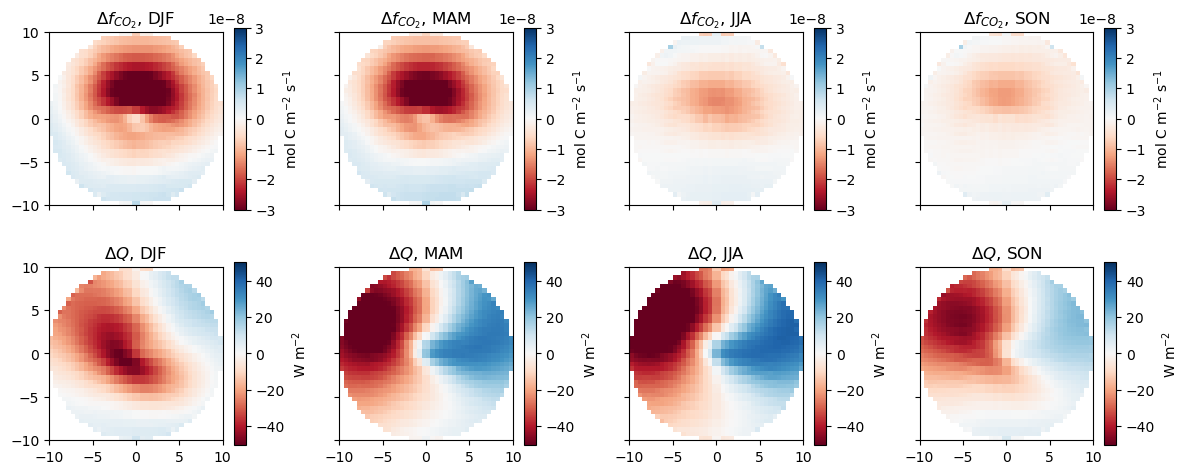

In [11]:
mon = ["DJF", "MAM", "JJA", "SON"]

fig, axs = plt.subplots(ncols=4, nrows=2, sharey=True, sharex=True, figsize=(12,5))
axs=axs.flatten()

for i, name in enumerate(mon):
    dic_season.sel(season=name).plot(ax=axs[i], y='y', vmin=-3e-8, vmax=3e-8, cmap="RdBu", extend="neither",
                                    cbar_kwargs={"aspect":15, "shrink":0.9, "label":"mol C m$^{-2}$ s$^{-1}$"})
    axs[i].set_title('$\Delta f_{CO_2}$' + f', {mon[i]}')
    heat_season.sel(season=name).plot(ax=axs[4+i], y='y', vmin=-50, vmax=50, cmap="RdBu", extend="neither",
                                     cbar_kwargs={"aspect":15, "shrink":0.9, "label":"W m$^{-2}$"})
    axs[i+4].set_title('$\Delta Q$' + f', {mon[i]}')
    
for i in np.arange(8):
    axs[i].set_aspect(1)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    
plt.tight_layout()
plt.savefig("/home/Katherine.Turner/Figures/fluxes_seasonal.png", format="png", dpi=100)

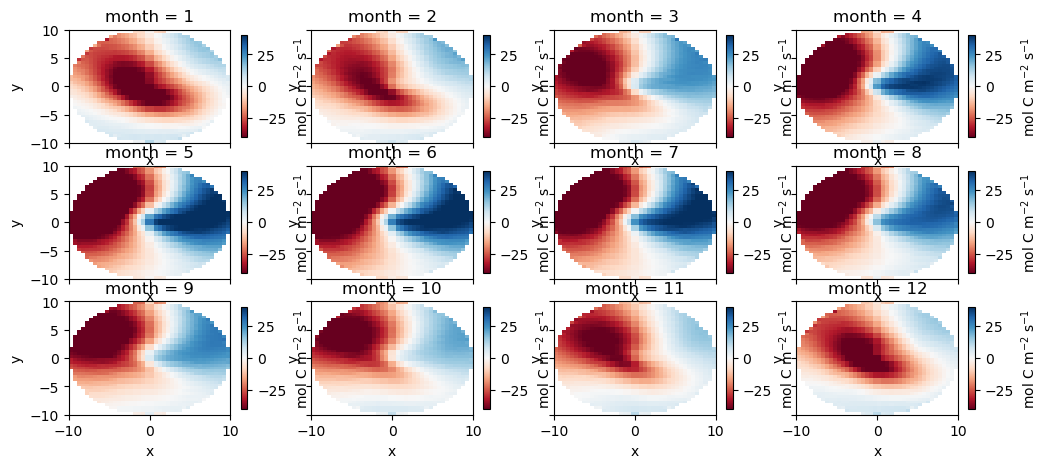

In [6]:
heat_m = heat_masked.groupby(time2.dt.month).mean()

fig, axs = plt.subplots(ncols=4, nrows=3, sharey=True, sharex=True, figsize=(12,5))
axs=axs.flatten()

for i in np.arange(12):
    heat_m[:,:,i].plot(ax=axs[i], y='y', vmin=-40, vmax=40, cmap="RdBu", extend="neither",
                                    cbar_kwargs={"aspect":15, "shrink":0.9, "label":"mol C m$^{-2}$ s$^{-1}$"})

In [9]:
test = heat_masked.groupby(time2.dt.dayofyear).sum()

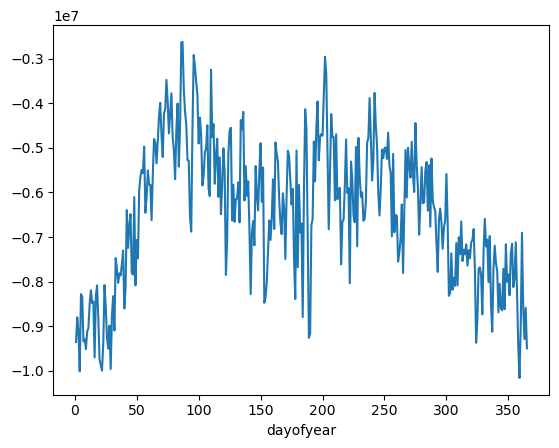

In [10]:
test.sum(dim=['x','y']).plot()